In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp

%matplotlib inline


In [3]:
df = pd.read_csv('data/titanic_train.csv', index_col = 'PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
#Количество пустых строк
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [7]:
#удалить столбецы Cabin и Name и Ticket 
temp = df.copy()
temp = temp.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [9]:
temp.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [15]:
#заменим в Sex: male :1 female : 0 
temp['Sex'] = temp['Sex'].map({'male':0, 'female':1})

In [17]:
temp.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,S
2,1,1,1,38.0,1,0,71.2833,C
3,1,3,1,26.0,0,0,7.9250,S
4,1,1,1,35.0,1,0,53.1000,S
5,0,3,0,35.0,0,0,8.0500,S


In [20]:
#заполнить пропуски в колонке Embarked соседними значениями
temp['Embarked'] = temp['Embarked'].fillna(method='pad')

In [24]:
#в колонку Age вставим данные в незаполненные строки с помощью интерполяции
temp['Age'] = temp['Age'].interpolate()

In [27]:
temp.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [28]:
#представим строковые данные как числовые
import sklearn.preprocessing as preprocessing

number_data = pd.get_dummies(temp)
number_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,3,0,22.0,1,0,7.2500,0,0,1
2,1,1,1,38.0,1,0,71.2833,1,0,0
3,1,3,1,26.0,0,0,7.9250,0,0,1
4,1,1,1,35.0,1,0,53.1000,0,0,1
5,0,3,0,35.0,0,0,8.0500,0,0,1


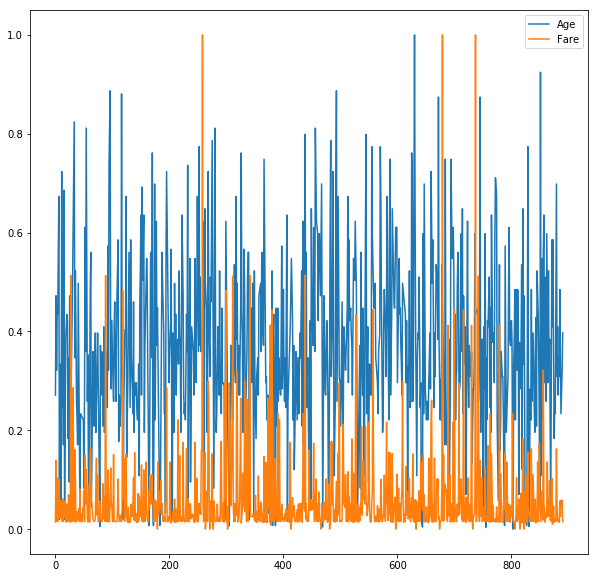

In [31]:
# Нормализация относительно минимального и максимального
mm_scalar = preprocessing.MinMaxScaler()
mm_scalar.fit(number_data)
mm_norm_number_data = pd.DataFrame(columns=number_data.columns, data=mm_scalar.transform(number_data)) 
mm_norm_number_data[['Age', 'Fare']].plot(figsize=(10, 10))

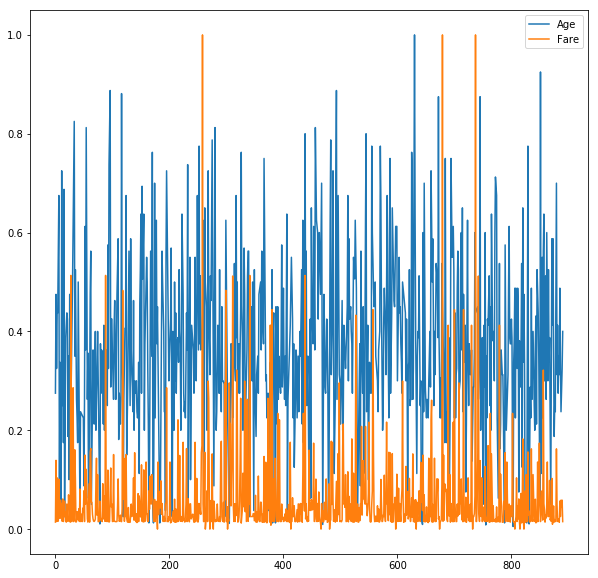

In [32]:
# нормализатор относительно максимально
ma_scaler = preprocessing.MaxAbsScaler()
ma_scaler.fit(number_data)
ma_norm_data = pd.DataFrame(columns=number_data.columns, data=ma_scaler.transform(number_data))
ma_norm_data[['Age', 'Fare']].plot(figsize=(10, 10))

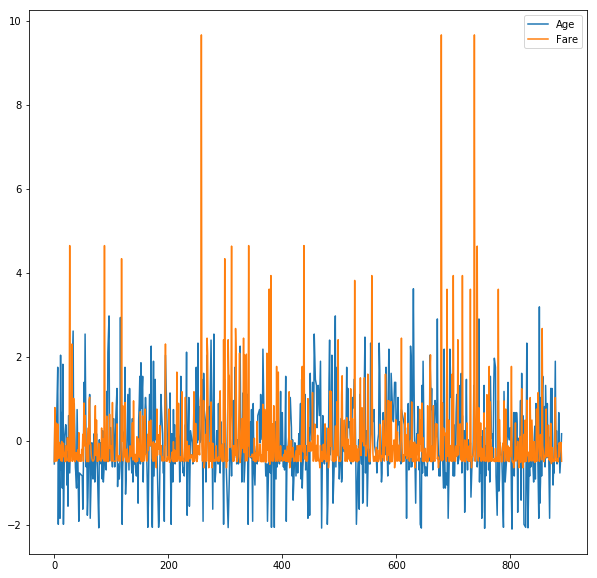

In [34]:
# Нормализация на основе дисперсии и мат. ожидания
std_scaler = preprocessing.StandardScaler()
std_scaler.fit(number_data)
std_norm_data = pd.DataFrame(columns=number_data.columns, data=std_scaler.transform(number_data))
std_norm_data[['Age', 'Fare']].plot(figsize=(10, 10))

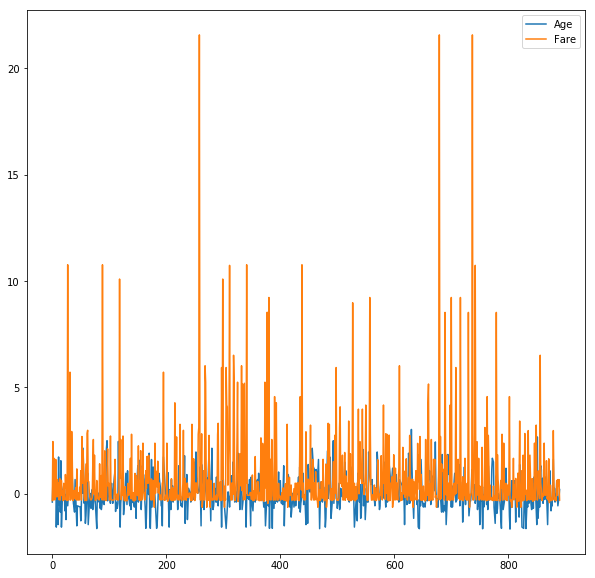

In [36]:
# Нормализация на основе дисперсии и мат. ожидания c удалением выбросов
std_clear_scaler = preprocessing.RobustScaler()
std_clear_scaler.fit(number_data)
std_clear_norm_data = pd.DataFrame(columns=number_data.columns, data=std_clear_scaler.transform(number_data))
std_clear_norm_data[['Age', 'Fare']].plot(figsize=(10, 10))

In [40]:
data = mm_norm_number_data.copy()

In [38]:
# создадим свой препроцессор
import sklearn.pipeline as pipeline
from sklearn.base import BaseEstimator, TransformerMixin


class DropOutlet(BaseEstimator):
    """
    Удаление выбросов, основываясь на правиле 3-х сигм (только для нормального распределения)
    """
        
    def fit(self, X: pd.DataFrame, y=None):
        """
        Получаем стандартное отклонение для каждого столбца и сохраняем их        
        """
        data.select_dtypes(include=['float', 'int'])
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        """
        Убираем все здачения, котоые находятся дальше 3-х стандартных отконений (сигма) от мат. ожидания случайной величины
        """
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    """
    Просто преобразует данные из DataFrame от pandas к матрице от numpy (ndarray)
    """
    
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    """
    Класс преобразует sparse matrix в ndarray
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preprocessing.LabelEncoder):
    """
    Стандартный костыль для препроцессора LabelEncoder
    """
    
    def fit(self, X, y=None):
        return super().fit(X)
    
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)

In [41]:
# Создадим наш pipeline
# drop_outlet, to_matrix, norm - это просто названия препроцессоров данное пользователем
# выбираем данные для обучающей выборки (то что будет подано на вход алгоритмам машинного обучения)
X_data = data[data.columns[:-1]].copy()
# Кодируем все классы в виде единичных векторов
X_data = pd.get_dummies(X_data)

# выбираем данные для обучающей выборки (то что будет на выходу алгоритмов машинного обучения)
Y_data = data[data.columns[-1]].copy()

# Убираем вылеты из данных
pipe_outlet = pipeline.Pipeline([
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)

# Соглачуем два массива X и Y
# Записи которые были удалены из массива X должны быть удалены и из массива Y
# Для удаления записей мы берем индексы из массива X и оставляем записи в массиве Y с индексами, которые есть в X
outletless_data_Y = Y_data[ Y_data.index.isin(outletless_data_X.index) ]

# Нормализуем данные X
pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preprocessing.MinMaxScaler())
])

# Нормализуем данные Y
pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
])

# вызываем препроцессоры
number_data_ready_X = pipe_x.fit_transform(outletless_data_X)
number_data_ready_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_ready_X.shape, number_data_ready_Y.shape)

(752, 9) (752,)


In [48]:
number_data_ready_X[:5,:]

array([[0.        , 1.        , 0.        , 0.30575234, 0.33333333,
        0.        , 0.04397492, 0.        , 0.        ],
       [1.        , 0.        , 1.        , 0.53244545, 0.33333333,
        0.        , 0.4323693 , 1.        , 0.        ],
       [1.        , 1.        , 1.        , 0.36242562, 0.        ,
        0.        , 0.04806914, 0.        , 0.        ],
       [1.        , 0.        , 1.        , 0.48994049, 0.33333333,
        0.        , 0.32207838, 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.48994049, 0.        ,
        0.        , 0.04882733, 0.        , 0.        ]])

In [49]:
number_data_ready_Y

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,